[Expt/trainable-forgetting-decay](https://github.com/open-spaced-repetition/fsrs-optimizer/tree/Expt/trainable-forgetting-decay)

In [1]:
import numpy as np
import pandas as pd
import os
import sys

sys.path.insert(0, os.path.abspath("../fsrs-optimizer/src/fsrs_optimizer/"))

from fsrs_optimizer import simulate, Optimizer

initial_parameters = [
    1.1596,
    1.7974,
    13.1205,
    49.3729,
    7.2303,
    0.5081,
    1.5371,
    0.0010,
    1.5052,
    0.1261,
    0.9735,
    1.8924,
    0.1486,
    0.2407,
    2.1937,
    0.1518,
    3.0699,
    0,
    0,
    1,
]


def generate_revlog_from_simulation(initial_parameters, learn_span):
    _, _, _, _, _, revlogs = simulate(
        w=initial_parameters,
        request_retention=0.8,
        learn_span=learn_span,
        first_rating_offset=np.array([0, 0, 0, 0]),
        first_session_len=np.array([0, 0, 0, 0]),
        forget_rating_offset=0,
        forget_session_len=0,
        fuzz=True,
    )

    flattened_revlogs = []

    for day in revlogs:
        card_ids = revlogs[day]["card_id"]
        ratings = revlogs[day]["rating"]
        for card_id, rating in zip(card_ids, ratings):
            flattened_revlogs.append(
                {"card_id": card_id, "review_rating": int(rating), "day": day}
            )
    return flattened_revlogs

In [2]:
from itertools import accumulate


def preprocess_revlog(flattened_revlogs):
    df = pd.DataFrame(flattened_revlogs)
    df["review_time"] = range(1, df.shape[0] + 1)
    df.sort_values(by=["card_id", "day"], inplace=True, ignore_index=True)
    df["delta_t"] = df.groupby("card_id")["day"].diff().fillna(0).astype(int)
    df["i"] = df.groupby("card_id").cumcount() + 1
    df.loc[df["i"] == 1, "delta_t"] = -1

    def cum_concat(x):
        return list(accumulate(x))

    t_history_list = df.groupby("card_id", group_keys=False)["delta_t"].apply(
        lambda x: cum_concat([[max(0, int(i))] for i in x])
    )
    df["t_history"] = [
        ",".join(map(str, item[:-1])) for sublist in t_history_list for item in sublist
    ]
    r_history_list = df.groupby("card_id", group_keys=False)["review_rating"].apply(
        lambda x: cum_concat([[i] for i in x])
    )
    df["r_history"] = [
        ",".join(map(str, item[:-1])) for sublist in r_history_list for item in sublist
    ]
    last_rating = []
    for t_sublist, r_sublist in zip(t_history_list, r_history_list):
        for t_history, r_history in zip(t_sublist, r_sublist):
            flag = True
            for t, r in zip(reversed(t_history[:-1]), reversed(r_history[:-1])):
                if t > 0:
                    last_rating.append(r)
                    flag = False
                    break
            if flag:
                last_rating.append(r_history[0])
    df["last_rating"] = last_rating
    df = df[
        (df["review_rating"] != 0)
        & (df["r_history"].str.contains("0") == 0)
        & (df["delta_t"] != 0)
    ].copy()

    df["i"] = df.groupby("card_id").cumcount() + 1
    df["first_rating"] = df["r_history"].map(lambda x: x[0] if len(x) > 0 else "")
    df["y"] = df["review_rating"].map(lambda x: {1: 0, 2: 1, 3: 1, 4: 1}[x])
    df = df[(df["i"] > 1) & (df["delta_t"] > 0)].copy()
    return df

In [3]:
import matplotlib.pyplot as plt

decay_list = []

def train_and_evaluate(df):
    plt.close("all")
    sample_size = len(df)
    print(f"sample size: {sample_size}")
    optimizer = Optimizer(enable_short_term=False)
    optimizer.S0_dataset_group = (
        df[df["i"] == 2]
        .groupby(by=["first_rating", "delta_t"], group_keys=False)
        .agg({"y": ["mean", "count"]})
        .reset_index()
    )
    optimizer.define_model()
    optimizer.pretrain(dataset=df, verbose=False)
    optimizer.train(gamma=0, verbose=False)
    print(optimizer.w)
    decay_list.append(optimizer.w[19])
    loss_before, loss_after = optimizer.evaluate(save_to_file=False)
    print(f"loss before: {loss_before:.4f}, loss after: {loss_after:.4f}")
    metrics, figures = optimizer.calibration_graph(verbose=False)
    rmse = metrics["all"]["RMSE(bins)"]
    auc = metrics["all"]["AUC"]
    print(f"RMSE(bins): {rmse:.4f}")
    print(f"AUC: {auc:.4f}")
    deviations = []
    for param, trained_param in zip(initial_parameters, optimizer.w):
        if param == 0 and trained_param == 0:
            continue
        smape = abs(param - trained_param) / ((abs(param) + abs(trained_param)) / 2)
        deviations.append(smape)
        print(f"{param} -> {trained_param}: SMAPE={smape:.4%}")
    avg_smape = np.mean(deviations)
    print(f"Avg. SMAPE: {avg_smape:.4%}")
    return sample_size, loss_after, rmse, auc, avg_smape, optimizer.dataset

def evaluate_initial_parameters(dataset):
    optimizer = Optimizer()
    optimizer.dataset = dataset
    optimizer.w = initial_parameters
    loss_before, loss_after = optimizer.evaluate(save_to_file=False)
    print(f"loss before: {loss_before:.4f}, loss after: {loss_after:.4f}")
    metrics, figures = optimizer.calibration_graph(verbose=False)
    rmse = metrics["all"]["RMSE(bins)"]
    auc = metrics["all"]["AUC"]
    print(f"RMSE(bins): {rmse:.4f}")
    print(f"AUC: {auc:.4f}")
    return loss_after, rmse, auc

learn_span: 30


sample size: 1274


  0%|          | 0/1274 [00:00<?, ?it/s]

[0.9995, 2.9623, 20.6862, 100.0, 7.1815, 0.4957, 1.3678, 0.012, 1.5527, 0.0939, 1.0276, 1.8481, 0.2047, 0.2162, 2.1662, 0.1882, 3.1575, 0.0, 0.0, 0.3164]
loss before: 0.5174, loss after: 0.4866
RMSE(bins): 0.0488
AUC: 0.5903
1.1596 -> 0.9995: SMAPE=14.8303%
1.7974 -> 2.9623: SMAPE=48.9485%
13.1205 -> 20.6862: SMAPE=44.7586%
49.3729 -> 100.0: SMAPE=67.7862%
7.2303 -> 7.1815: SMAPE=0.6772%
0.5081 -> 0.4957: SMAPE=2.4706%
1.5371 -> 1.3678: SMAPE=11.6562%
0.001 -> 0.012: SMAPE=169.2308%
1.5052 -> 1.5527: SMAPE=3.1067%
0.1261 -> 0.0939: SMAPE=29.2727%
0.9735 -> 1.0276: SMAPE=5.4070%
1.8924 -> 1.8481: SMAPE=2.3687%
0.1486 -> 0.2047: SMAPE=31.7577%
0.2407 -> 0.2162: SMAPE=10.7244%
2.1937 -> 2.1662: SMAPE=1.2615%
0.1518 -> 0.1882: SMAPE=21.4118%
3.0699 -> 3.1575: SMAPE=2.8134%
1 -> 0.3164: SMAPE=103.8590%
Avg. SMAPE: 31.7967%
loss before: 0.5174, loss after: 0.4920
RMSE(bins): 0.0561
AUC: 0.5641
--------------------------------
learn_span: 60


sample size: 3629


  0%|          | 0/3629 [00:00<?, ?it/s]

[1.2801, 2.2234, 15.2033, 78.193, 7.3384, 0.4039, 1.4849, 0.034, 1.4045, 0.3734, 0.8967, 1.8574, 0.2115, 0.2445, 2.1712, 0.219, 3.2051, 0.0, 0.0, 0.3297]
loss before: 0.5410, loss after: 0.4829
RMSE(bins): 0.0286
AUC: 0.5640
1.1596 -> 1.2801: SMAPE=9.8783%
1.7974 -> 2.2234: SMAPE=21.1898%
13.1205 -> 15.2033: SMAPE=14.7071%
49.3729 -> 78.193: SMAPE=45.1846%
7.2303 -> 7.3384: SMAPE=1.4840%
0.5081 -> 0.4039: SMAPE=22.8509%
1.5371 -> 1.4849: SMAPE=3.4547%
0.001 -> 0.034: SMAPE=188.5714%
1.5052 -> 1.4045: SMAPE=6.9217%
0.1261 -> 0.3734: SMAPE=99.0190%
0.9735 -> 0.8967: SMAPE=8.2130%
1.8924 -> 1.8574: SMAPE=1.8668%
0.1486 -> 0.2115: SMAPE=34.9347%
0.2407 -> 0.2445: SMAPE=1.5664%
2.1937 -> 2.1712: SMAPE=1.0310%
0.1518 -> 0.219: SMAPE=36.2460%
3.0699 -> 3.2051: SMAPE=4.3092%
1 -> 0.3297: SMAPE=100.8197%
Avg. SMAPE: 33.4582%
loss before: 0.5410, loss after: 0.4853
RMSE(bins): 0.0333
AUC: 0.5580
--------------------------------
learn_span: 120


sample size: 8025


  0%|          | 0/8025 [00:00<?, ?it/s]

[1.1241, 1.7042, 11.9693, 38.0844, 7.1, 0.3317, 1.4954, 0.001, 1.4896, 0.181, 0.9799, 1.8505, 0.2057, 0.2482, 2.3148, 0.0846, 2.8409, 0.0, 0.0, 0.3212]
loss before: 0.5548, loss after: 0.5168
RMSE(bins): 0.0333
AUC: 0.5497
1.1596 -> 1.1241: SMAPE=3.1090%
1.7974 -> 1.7042: SMAPE=5.3233%
13.1205 -> 11.9693: SMAPE=9.1766%
49.3729 -> 38.0844: SMAPE=25.8149%
7.2303 -> 7.1: SMAPE=1.8185%
0.5081 -> 0.3317: SMAPE=42.0100%
1.5371 -> 1.4954: SMAPE=2.7502%
0.001 -> 0.001: SMAPE=0.0000%
1.5052 -> 1.4896: SMAPE=1.0418%
0.1261 -> 0.181: SMAPE=35.7538%
0.9735 -> 0.9799: SMAPE=0.6553%
1.8924 -> 1.8505: SMAPE=2.2389%
0.1486 -> 0.2057: SMAPE=32.2326%
0.2407 -> 0.2482: SMAPE=3.0681%
2.1937 -> 2.3148: SMAPE=5.3721%
0.1518 -> 0.0846: SMAPE=56.8528%
3.0699 -> 2.8409: SMAPE=7.7485%
1 -> 0.3212: SMAPE=102.7551%
Avg. SMAPE: 18.7623%
loss before: 0.5548, loss after: 0.5176
RMSE(bins): 0.0334
AUC: 0.5461
--------------------------------
learn_span: 240


sample size: 18091


  0%|          | 0/18091 [00:00<?, ?it/s]

[1.029, 2.022, 13.1496, 37.6241, 7.2576, 0.3384, 1.4833, 0.0082, 1.4899, 0.117, 1.0072, 1.846, 0.1627, 0.2473, 2.2506, 0.1745, 2.7724, 0.0, 0.0, 0.3429]
loss before: 0.5308, loss after: 0.4989
RMSE(bins): 0.0227
AUC: 0.5583
1.1596 -> 1.029: SMAPE=11.9346%
1.7974 -> 2.022: SMAPE=11.7610%
13.1205 -> 13.1496: SMAPE=0.2215%
49.3729 -> 37.6241: SMAPE=27.0097%
7.2303 -> 7.2576: SMAPE=0.3769%
0.5081 -> 0.3384: SMAPE=40.0945%
1.5371 -> 1.4833: SMAPE=3.5624%
0.001 -> 0.0082: SMAPE=156.5217%
1.5052 -> 1.4899: SMAPE=1.0217%
0.1261 -> 0.117: SMAPE=7.4866%
0.9735 -> 1.0072: SMAPE=3.4028%
1.8924 -> 1.846: SMAPE=2.4823%
0.1486 -> 0.1627: SMAPE=9.0588%
0.2407 -> 0.2473: SMAPE=2.7049%
2.1937 -> 2.2506: SMAPE=2.5606%
0.1518 -> 0.1745: SMAPE=13.9136%
3.0699 -> 2.7724: SMAPE=10.1843%
1 -> 0.3429: SMAPE=97.8628%
Avg. SMAPE: 22.3423%
loss before: 0.5308, loss after: 0.4993
RMSE(bins): 0.0228
AUC: 0.5549
--------------------------------
learn_span: 480


sample size: 38912


  0%|          | 0/38912 [00:00<?, ?it/s]

[1.1301, 1.8197, 12.6634, 49.5834, 7.1021, 0.4339, 1.4342, 0.001, 1.4462, 0.1698, 1.0511, 1.8346, 0.2171, 0.259, 2.4742, 0.1638, 2.87, 0.0, 0.0, 0.354]
loss before: 0.5281, loss after: 0.5020
RMSE(bins): 0.0183
AUC: 0.5428
1.1596 -> 1.1301: SMAPE=2.5768%
1.7974 -> 1.8197: SMAPE=1.2330%
13.1205 -> 12.6634: SMAPE=3.5456%
49.3729 -> 49.5834: SMAPE=0.4254%
7.2303 -> 7.1021: SMAPE=1.7890%
0.5081 -> 0.4339: SMAPE=15.7537%
1.5371 -> 1.4342: SMAPE=6.9263%
0.001 -> 0.001: SMAPE=0.0000%
1.5052 -> 1.4462: SMAPE=3.9981%
0.1261 -> 0.1698: SMAPE=29.5370%
0.9735 -> 1.0511: SMAPE=7.6657%
1.8924 -> 1.8346: SMAPE=3.1017%
0.1486 -> 0.2171: SMAPE=37.4624%
0.2407 -> 0.259: SMAPE=7.3244%
2.1937 -> 2.4742: SMAPE=12.0183%
0.1518 -> 0.1638: SMAPE=7.6046%
3.0699 -> 2.87: SMAPE=6.7308%
1 -> 0.354: SMAPE=95.4210%
Avg. SMAPE: 13.5063%
loss before: 0.5281, loss after: 0.5021
RMSE(bins): 0.0183
AUC: 0.5430
--------------------------------
learn_span: 960


sample size: 72901


  0%|          | 0/72901 [00:00<?, ?it/s]

[1.2158, 2.0148, 12.791, 47.2239, 6.9295, 0.4603, 1.3643, 0.0013, 1.3535, 0.1389, 1.0239, 1.6395, 0.2077, 0.2671, 2.4884, 0.1325, 3.0349, 0.0, 0.0, 0.2989]
loss before: 0.5253, loss after: 0.5040
RMSE(bins): 0.0168
AUC: 0.5399
1.1596 -> 1.2158: SMAPE=4.7318%
1.7974 -> 2.0148: SMAPE=11.4055%
13.1205 -> 12.791: SMAPE=2.5433%
49.3729 -> 47.2239: SMAPE=4.4494%
7.2303 -> 6.9295: SMAPE=4.2486%
0.5081 -> 0.4603: SMAPE=9.8720%
1.5371 -> 1.3643: SMAPE=11.9115%
0.001 -> 0.0013: SMAPE=26.0870%
1.5052 -> 1.3535: SMAPE=10.6132%
0.1261 -> 0.1389: SMAPE=9.6604%
0.9735 -> 1.0239: SMAPE=5.0466%
1.8924 -> 1.6395: SMAPE=14.3209%
0.1486 -> 0.2077: SMAPE=33.1743%
0.2407 -> 0.2671: SMAPE=10.3978%
2.1937 -> 2.4884: SMAPE=12.5884%
0.1518 -> 0.1325: SMAPE=13.5772%
3.0699 -> 3.0349: SMAPE=1.1466%
1 -> 0.2989: SMAPE=107.9529%
Avg. SMAPE: 16.3182%
loss before: 0.5253, loss after: 0.5042
RMSE(bins): 0.0175
AUC: 0.5408
--------------------------------


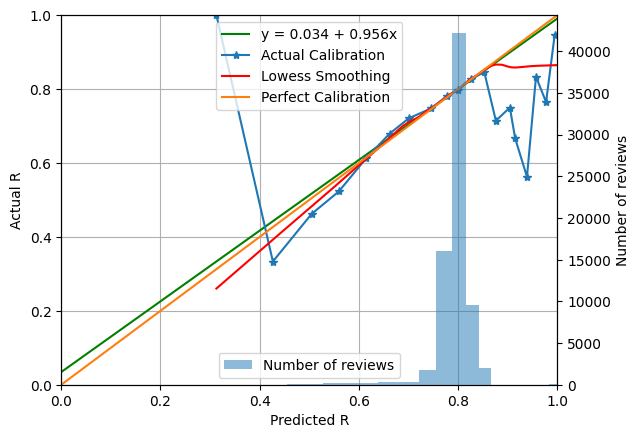

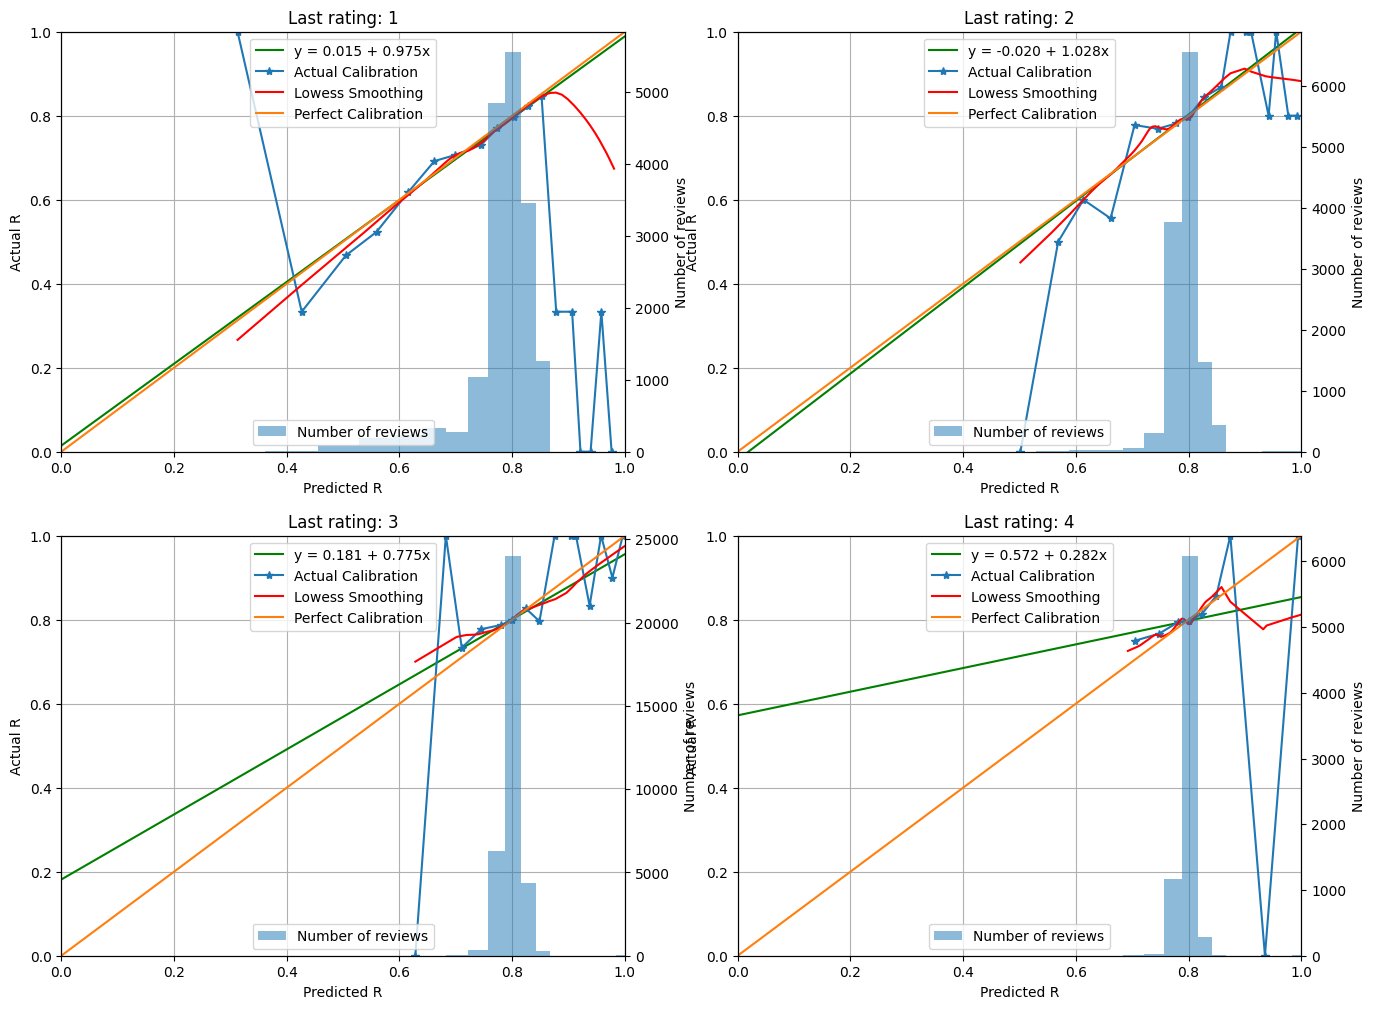

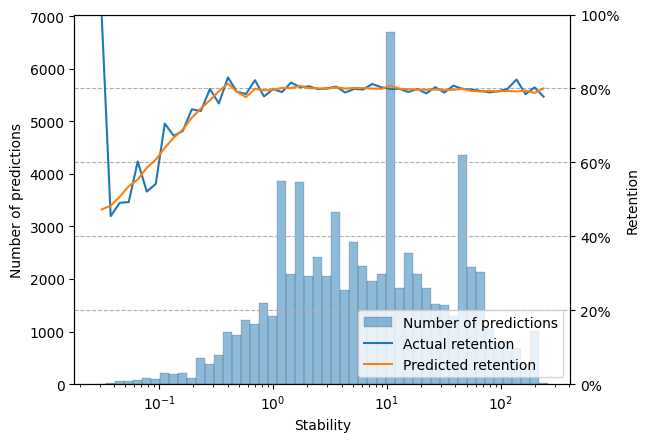

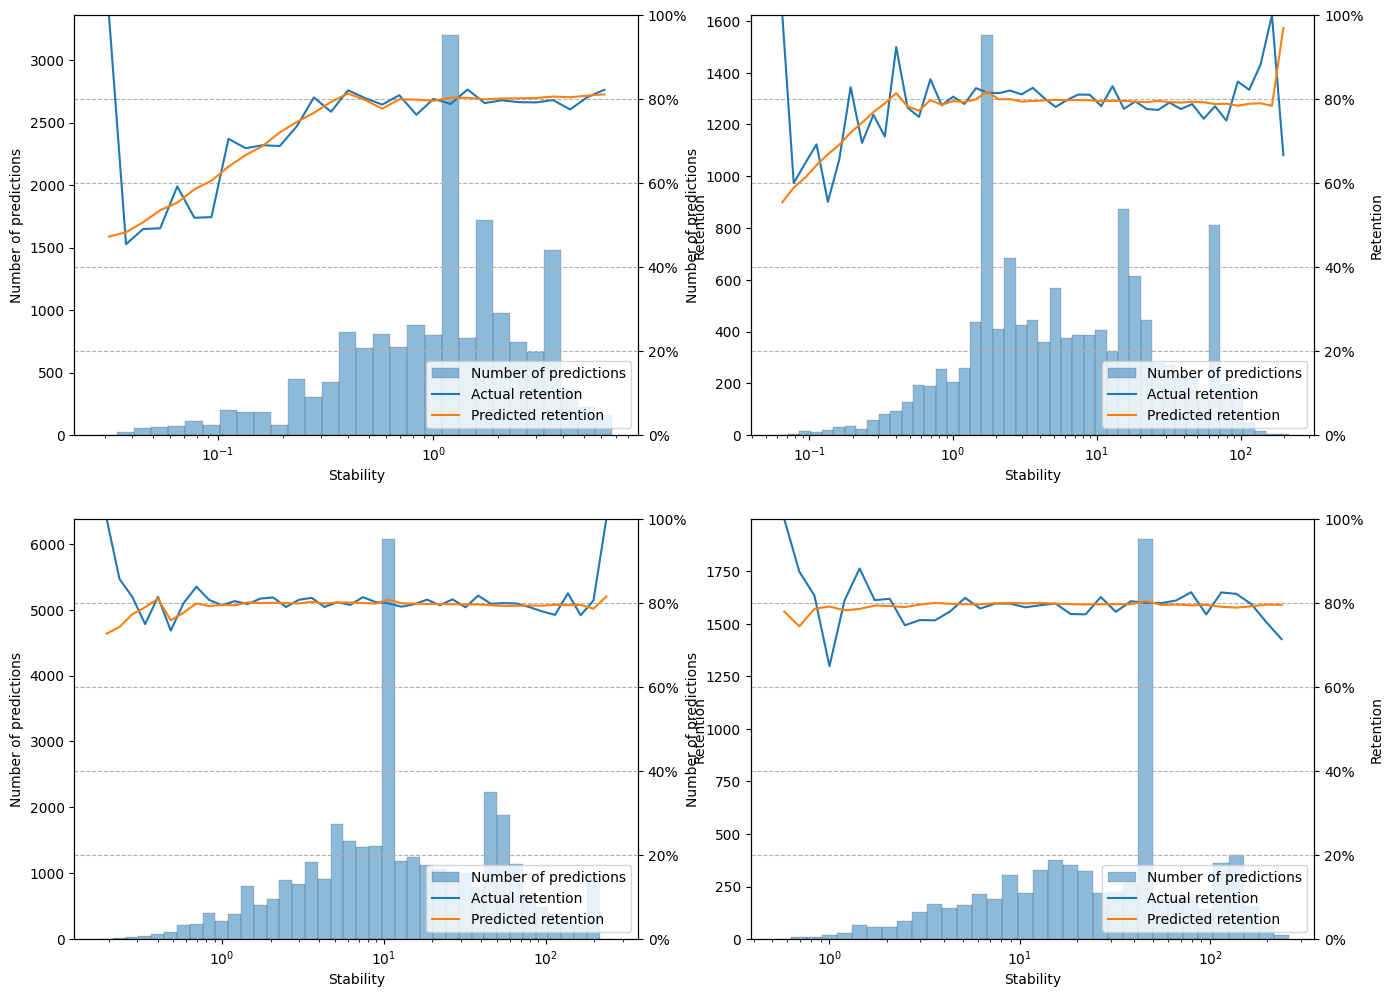

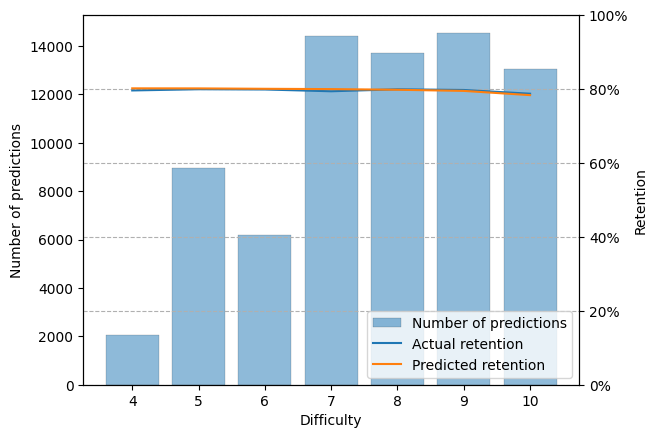

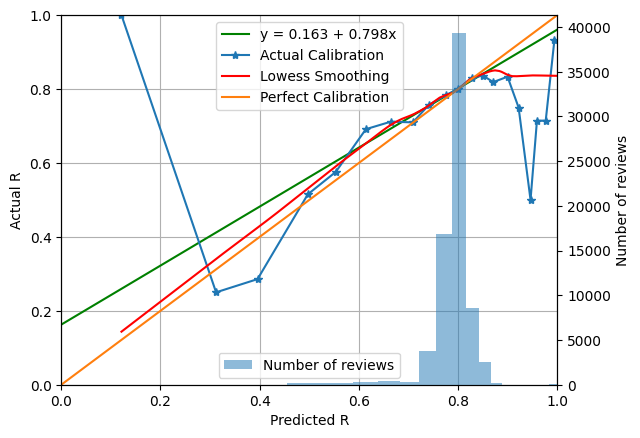

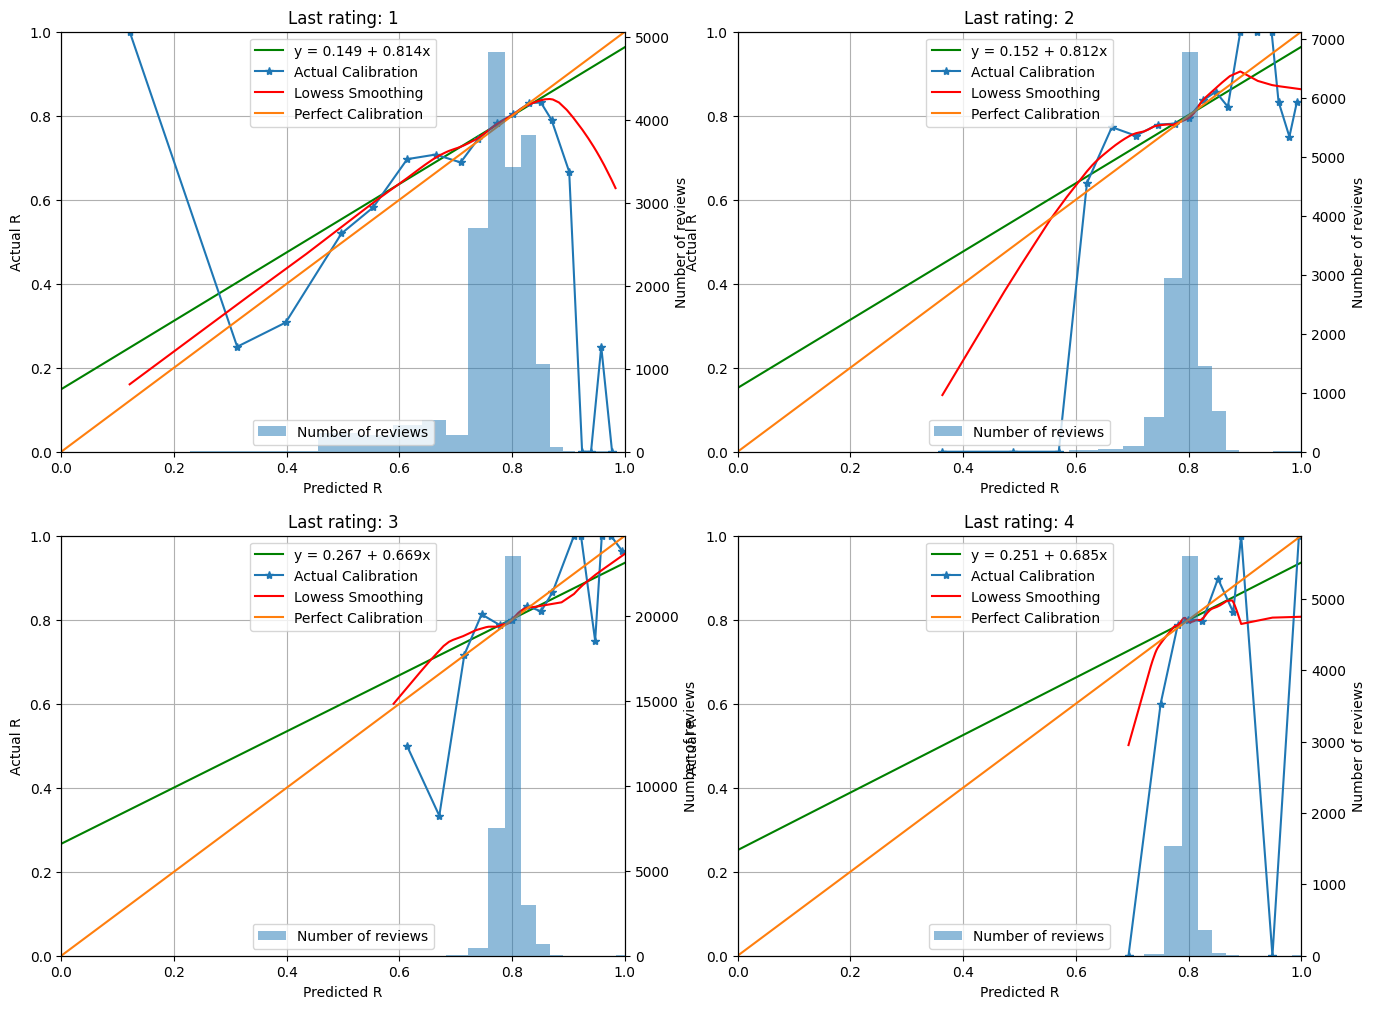

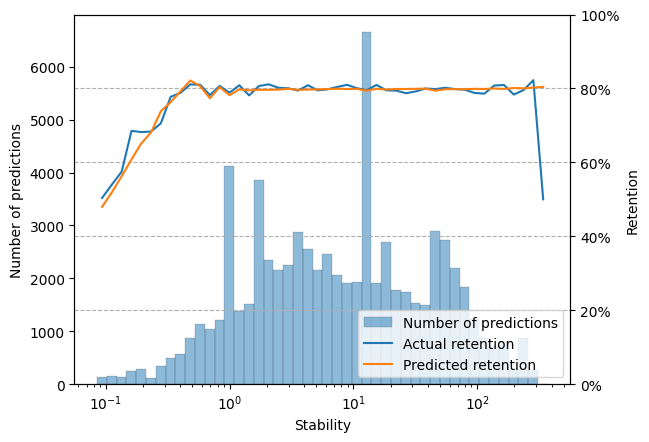

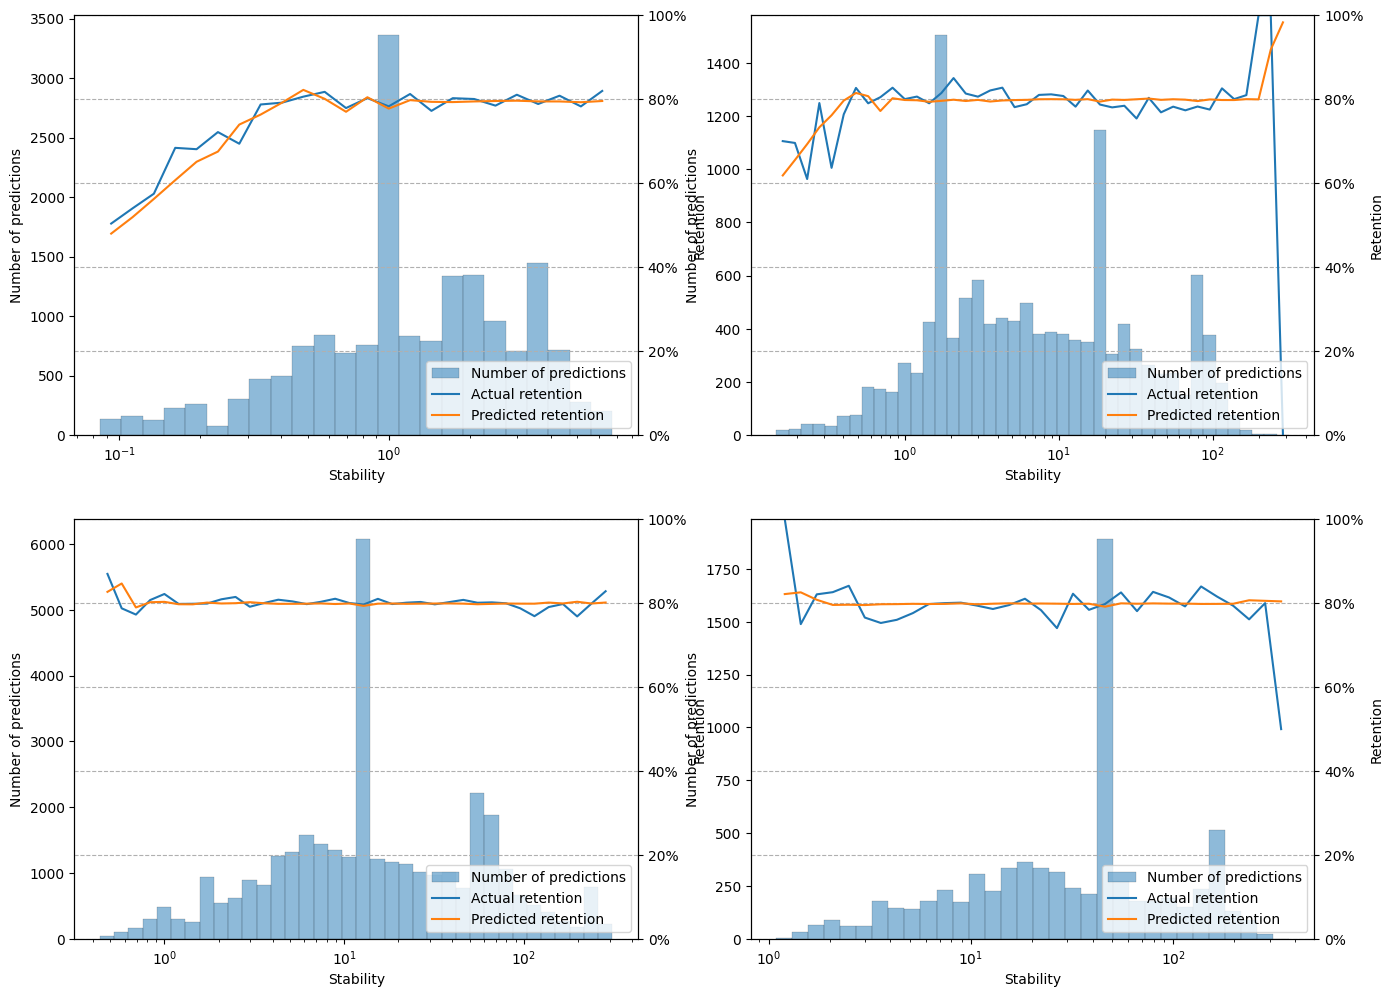

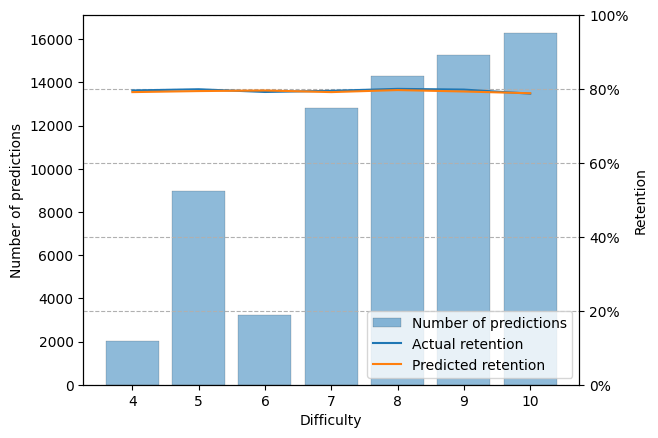

In [4]:
learn_span_list = [30, 60, 120, 240, 480, 960]
sample_size_list = []
logloss_list = []
rmse_list = []
auc_list = []
avg_smape_list = []
ideal_logloss_list = []
ideal_rmse_list = []
ideal_auc_list = []

for learn_span in learn_span_list:
    print(f"learn_span: {learn_span}")
    revlogs = generate_revlog_from_simulation(initial_parameters, learn_span=learn_span)
    df = preprocess_revlog(revlogs)
    sample_size, logloss, rmse, auc, avg_smape, dataset = train_and_evaluate(df)
    sample_size_list.append(sample_size)
    logloss_list.append(logloss)
    rmse_list.append(rmse)
    auc_list.append(auc)
    avg_smape_list.append(avg_smape)

    ideal_logloss, ideal_rmse, ideal_auc = evaluate_initial_parameters(dataset)
    ideal_logloss_list.append(ideal_logloss)
    ideal_rmse_list.append(ideal_rmse)
    ideal_auc_list.append(ideal_auc)

    print("--------------------------------")

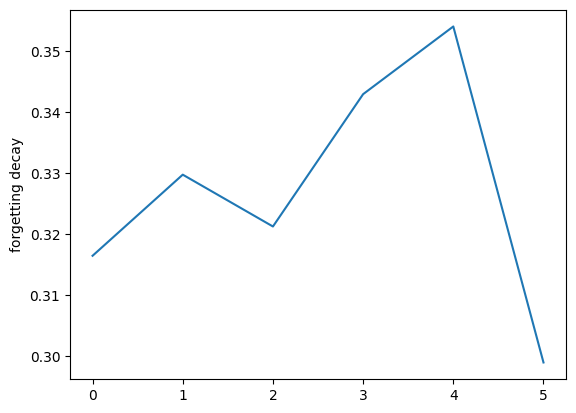

In [5]:
plt.plot(decay_list)
plt.ylabel("forgetting decay")
plt.show()

In [6]:
np.set_printoptions(precision=6, suppress=True)
print(f"logloss (trained - ideal): {np.array(logloss_list) - np.array(ideal_logloss_list)}")
print(f"RMSE(bins) (trained - ideal): {np.array(rmse_list) - np.array(ideal_rmse_list)}")
print(f"AUC (trained - ideal): {np.array(auc_list) - np.array(ideal_auc_list)}")

logloss (trained - ideal): [-0.005389 -0.002357 -0.000879 -0.000444 -0.000166 -0.000215]
RMSE(bins) (trained - ideal): [-0.007345 -0.004696 -0.00013  -0.000141 -0.000047 -0.00074 ]
AUC (trained - ideal): [ 0.026236  0.00596   0.003606  0.003393 -0.000171 -0.000963]


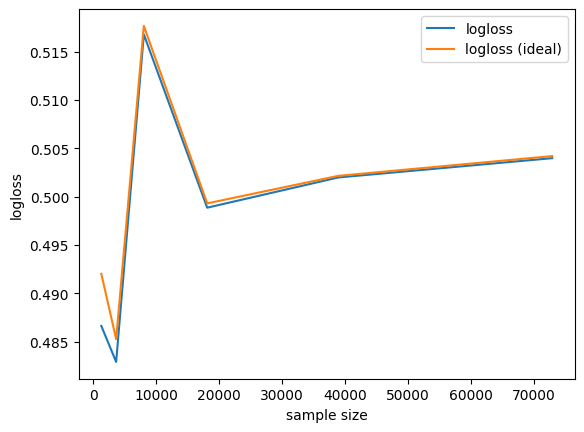

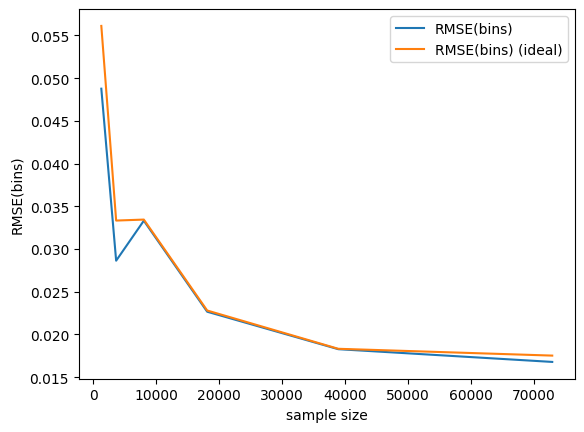

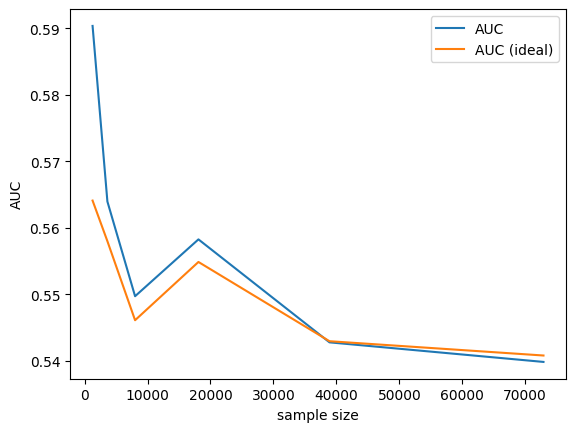

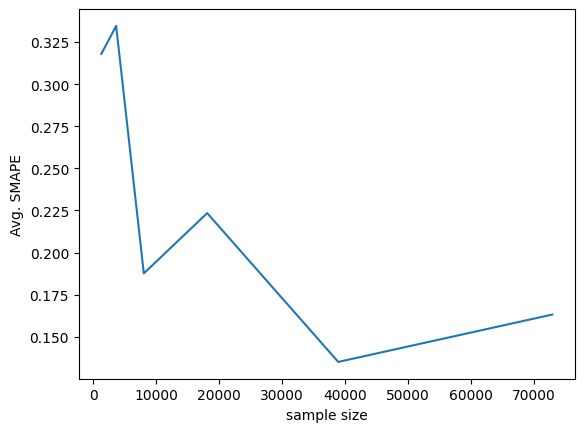

In [7]:
plt.plot(sample_size_list, logloss_list, label="logloss")
plt.plot(sample_size_list, ideal_logloss_list, label="logloss (ideal)")
plt.ylabel("logloss")
plt.xlabel("sample size")
plt.legend()
plt.show()
plt.plot(sample_size_list, rmse_list, label="RMSE(bins)")
plt.plot(sample_size_list, ideal_rmse_list, label="RMSE(bins) (ideal)")
plt.ylabel("RMSE(bins)")
plt.xlabel("sample size")
plt.legend()
plt.show()
plt.plot(sample_size_list, auc_list, label="AUC")
plt.plot(sample_size_list, ideal_auc_list, label="AUC (ideal)")
plt.ylabel("AUC")
plt.xlabel("sample size")
plt.legend()
plt.show()
plt.plot(sample_size_list, avg_smape_list)
plt.ylabel("Avg. SMAPE")
plt.xlabel("sample size")
plt.show()


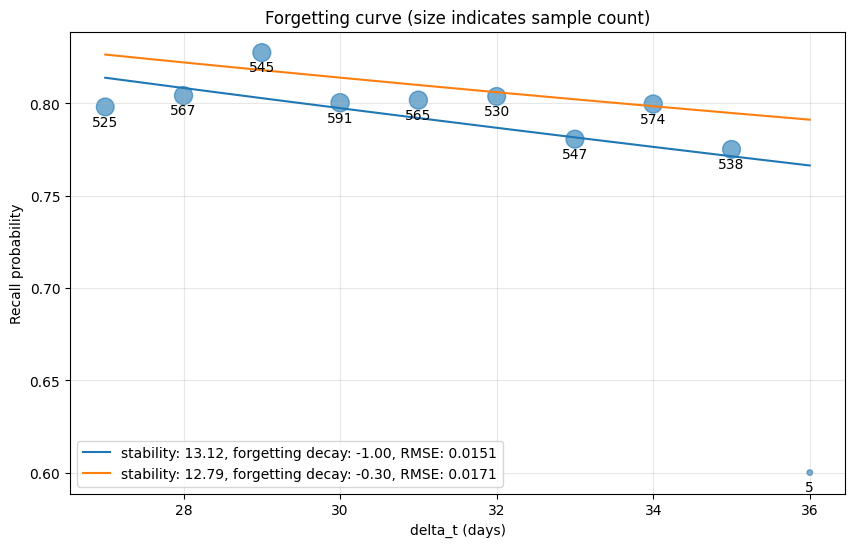

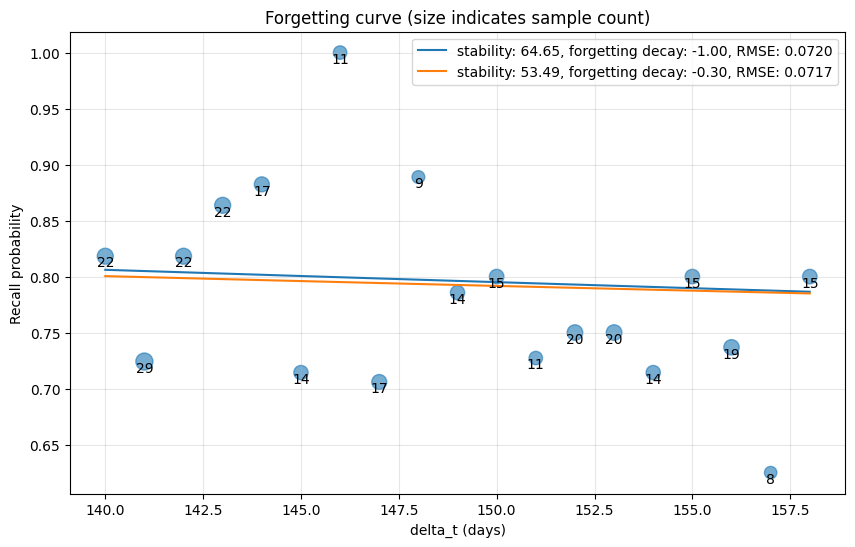

In [8]:
from fsrs_optimizer import power_forgetting_curve
from sklearn.metrics import root_mean_squared_error

trained_parameters = [
    1.2158,
    2.0148,
    12.791,
    47.2239,
    6.9295,
    0.4603,
    1.3643,
    0.0013,
    1.3535,
    0.1389,
    1.0239,
    1.6395,
    0.2077,
    0.2671,
    2.4884,
    0.1325,
    3.0349,
    0.0,
    0.0,
    0.2989,
]

initial = Optimizer()
initial.dataset = dataset.copy()
initial.w = initial_parameters
loss_before, loss_after = initial.evaluate(save_to_file=False)
trained = Optimizer()
trained.dataset = dataset.copy()
trained.w = trained_parameters
loss_before, loss_after = trained.evaluate(save_to_file=False)
for r_history, t_history in [("3", "0"), ("3,3", "0,30")]:
    stabilities = []
    for df in [initial.dataset, trained.dataset]:
        tmp = df[(df["r_history"] == r_history) & (df["t_history"] == t_history)]
        points = tmp.groupby("delta_t")["y"].agg(["mean", "count"])
        stabilities.append(tmp["stability"].unique()[0])
    y_true = points["mean"]
    plt.figure(figsize=(10, 6))
    plt.scatter(points.index, y_true, s=np.sqrt(points["count"] / sum(points["count"])) * 500, alpha=0.6)
    for x, y in zip(points.index, y_true):
        plt.text(x, y - 0.012, points["count"][x], ha='center', va='bottom')

    for s, d in zip(stabilities, [initial_parameters[19], trained_parameters[19]]):
        y_pred = power_forgetting_curve(points.index, s, -d)
        rmse = root_mean_squared_error(y_true, y_pred, sample_weight=points["count"])
        plt.plot(
            points.index,
            y_pred,
            label=f"stability: {s:.2f}, forgetting decay: {-d:.2f}, RMSE: {rmse:.4f}",
        )
    plt.xlabel("delta_t (days)")
    plt.ylabel("Recall probability")
    plt.title("Forgetting curve (size indicates sample count)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()